# Self Driving car

## Traffic Sign classifier

This notebook presents a implementation of a image classifier performed on German Traffic Signs Dataset

In [1]:
import numpy as np
import pandas as pd
import csv
import cv2 
import matplotlib.pyplot as plt

### Read the training and test data

In [2]:
# %% Read training and test data
def readTrainData(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            im = cv2.imread((prefix + row[0]))
#            im = np.asarray(im)
            im = cv2.resize(im, (32,32))
            images.append(im) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    images = np.array(images)
    images = np.stack(images, axis = 0)
    labels = list(map(int, labels))
    labels = np.array(labels)
    return images, labels

def readTestData(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    prefix = rootpath + '/images/'  # subdirectory for class
    gtFile = open(rootpath + '/images/GT-final_test.csv') # annotations file
    gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
    next(gtReader) # skip header
    # loop over all images in current annotations file
    for row in gtReader:
        im = cv2.imread((prefix + row[0]))
        im = cv2.resize(im, (32,32))
#        im = np.asarray(im)
        images.append(im) # the 1th column is the filename
        labels.append(row[7]) # the 8th column is the label
    images = np.array(images)
    images = np.stack(images, axis = 0)
    labels = list(map(int, labels))
    labels = np.array(labels)
    gtFile.close()
    return images, labels


train_path = './train'
test_path = './test'
X_train, y_train = readTrainData(train_path)
X_test, y_test = readTestData(test_path)

### Information about the dataset

In [3]:
# %% Information about training and test data
n_train, n_test = X_train.shape[0], X_test.shape[0] # Number of examples
image_shape = X_train[0].shape # What's the shape of an traffic sign image?
n_classes = np.unique(y_train).shape[0] # Number of classees

print("Number of training examples =", n_train)
print("Number of testing examples  =", n_test)
print("Image data shape  =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 26640
Number of testing examples  = 12630
Image data shape  = (32, 32, 3)
Number of classes = 43


### Visualize images from each class

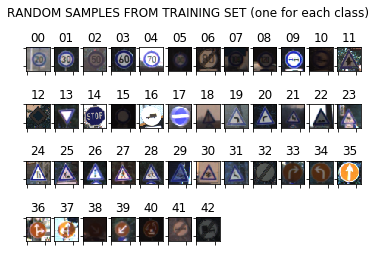

In [4]:
# %% Image visualization
#%matplotlib inline

# show a random sample from each class of the traffic sign dataset
rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols)
plt.suptitle('RANDOM SAMPLES FROM TRAINING SET (one for each class)')
for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        # show a random image of the current class
        cur_X = X_train[y_train == class_idx]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx))
    else:
        ax.axis('off')
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.draw()



### Visualize the data distribution in various classes

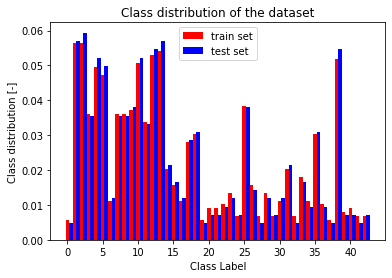

In [5]:
# Bar chart
training_distribution = np.zeros(n_classes)
test_distribution = np.zeros(n_classes)
for i in range (n_classes):
    training_distribution[i] = np.sum(y_train == i)/n_train
    test_distribution[i] = np.sum(y_test == i)/n_test
col_width = 0.5
plt.bar(np.arange(n_classes), training_distribution, width = col_width, color = 'r')
plt.bar(np.arange(n_classes)+col_width, test_distribution, width = col_width, color = 'b')
plt.xlabel('Class Label')
plt.ylabel('Class distribution [-]')
plt.title('Class distribution of the dataset')
plt.xticks(np.arange(0, n_classes, 5))
plt.legend(('train set', 'test set'))
plt.show()

# # Plot a histogram of the count of the number of examples of each sign
# # in the test set

# plt.hist(y_train, bins=n_classes)
# plt.title('Number of examples of each sign in the training set')
# plt.xlabel('Sign')
# plt.ylabel('Count')
# plt.plot()

The bar chart above shows that there is heavy imbalence of the data distribution over the various classes. However it is good news that the for each classes data is distributed failry equal between training and test sets

### Model design and architecture

The implementation will follow as per the paper [Sermanet, LeCun] with following steps
1. Preprocessing: All images are down-sampled or upsampled to 32x32 (dataset samples sizes vary from 15x15 to 250x250) and converted to YUV space. The Y channel is then preprocessed with global and local contrast normalization while U and V channels are left unchanged

In [6]:
import cv2
def feature_preprocessing(X):
    
    # Convert images from RGB to YUV and normalize
    def image_processing(img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img[:,:,0] = cv2.equalizeHist(img[:,:,0])
        img = np.array(img/255.0, dtype = np.float32)
        return img
    X = [image_processing(rgb_img) for rgb_img in X]
    return X

X_train_processed = np.stack(feature_preprocessing(X_train), axis = 0)
X_test_processed = np.stack(feature_preprocessing(X_test), axis = 0)



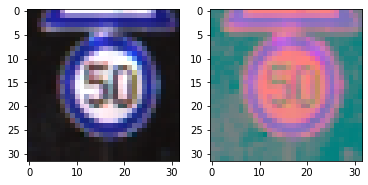

In [7]:
idx = 2000
fig, frames = plt.subplots(1, 2)
frames[0].imshow(X_train[idx])
frames[1].imshow(X_train_processed[idx])

In [8]:
# Shuffle training examples
from sklearn.utils import shuffle
X_train_processed, y_train_processed = shuffle(X_train_processed, y_train, random_state=42)
X_test_processed, y_test_processed = shuffle(X_test_processed, y_test, random_state=42)
y_test_processed = np.eye(n_classes, dtype='uint8')[y_test_processed]
y_train_processed = np.eye(n_classes, dtype='uint8')[y_train_processed]


#### Split data into training and validation sets

In [9]:
from sklearn.model_selection import train_test_split
# split the data into 80:20 
X_train_norm, X_val_norm, y_train_norm, y_val_norm = train_test_split(X_train_processed, y_train_processed, test_size = 0.2, random_state = 0)

### Data augmentation with keras

Using TensorFlow backend.


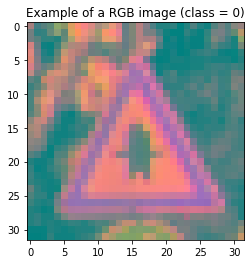

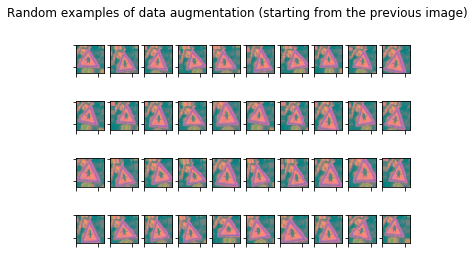

In [10]:
# create the generator to perform online data augmentation
from keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

# random image from the original training set
idx = 0
img_rgb = X_train_processed[idx]
plt.imshow(img_rgb)
plt.title('Example of a RGB image (class = {})'.format(y_train[idx]))
plt.show()


# plot augmented images of the selected image
fig, frames = plt.subplots(4, 10)
for frame in frames.ravel():
    augmented_img, _ = image_datagen.flow(np.expand_dims(img_rgb,axis=0), y_train[0:1]).next()
    frame.imshow(augmented_img[0])
plt.setp([a.get_xticklabels() for a in frames.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in frames.ravel()], visible=False)
plt.suptitle('Random examples of data augmentation (starting from the previous image)')
plt.show()


In [11]:
import numpy as np
from keras import layers
from keras.layers import Input, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image

def CNN_model(input_shape, n_classes):
    
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), padding='same', activation='relu')(X_input)
    X = Conv2D(32, (3, 3), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)

    X = Conv2D(64, (3, 3), padding='same', activation='relu')(X)
    X = Conv2D(64, (3, 3), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)

    X = Conv2D(128, (3, 3), padding='same', activation='relu')(X)
    X = Conv2D(128, (3, 3), activation='relu')(X)
    X = MaxPooling2D(pool_size=(2, 2))(X)
    X = Dropout(0.2)(X)

    X = Flatten()(X)
    X = Dense(512, activation='relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(n_classes, activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='CNN_model')    
    
    return model

In [12]:
# Create the model
from keras.optimizers import Adam
cnn_model = CNN_model(X_train.shape[1:], n_classes)

# Compile the model
cnn_model.compile(optimizer = Adam(lr=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
# training hyperparameters
BATCHSIZE = 128
EPOCHS = 20

In [14]:
'''
# fit the model
from keras.callbacks import ModelCheckpoint

image_datagen.fit(X_train_norm)
accuracy =[]
for epoch in range(EPOCHS):
    print("EPOCH {}".format(epoch + 1) + "/{}".format(EPOCHS))
    print('Model is training...')
    
    # fits the model on batches with real-time data augmentation:
    cnn_model.fit_generator(image_datagen.flow(X_train_norm, y_train_norm, batch_size=BATCHSIZE),
                            steps_per_epoch=len(X_train_norm) / 32, epochs=epoch)
    # Evaluate the data
    print('Model is evaluating...')
    train_accuracy = cnn_model.evaluate(X_train_norm, y_train_norm, batch_size=16, verbose=1, sample_weight=None)
    val_accuracy = cnn_model.evaluate(X_val_norm, y_val_norm, batch_size=16, verbose=1, sample_weight=None)
    print('Train Accuracy = {:.3f} - Validation Accuracy: {:.3f}'.format(train_accuracy[1], val_accuracy[1]))
    
    acc = [train_accuracy, val_accuracy]
    accuracy.append(acc)
    # save model
    filepath="./checkpoints/traffic_sign_model_epochs_" + str(epoch) +'.hd5'
    cnn_model.save(filepath)
'''
# # one-hot-encoding
# from keras.utils import to_categorical
# y_train_processed = to_categorical(y_train_processed)
# y_test_processed = to_categorical(y_test_processed)
# fit the model
from keras.callbacks import ModelCheckpoint

print('Model is training...')
epoch = EPOCHS
# fits the model on batches with real-time data augmentation:
cnn_model.fit(X_train_norm, y_train_norm, validation_data = (X_val_norm, y_val_norm), batch_size=BATCHSIZE, epochs=epoch, verbose = 1)

Model is training...
Instructions for updating:
Use tf.cast instead.
Train on 21312 samples, validate on 5328 samples
Epoch 1/20
21312/21312 [==============================] - 547s 26ms/step - loss: 2.9788 - acc: 0.1778 - val_loss: 1.4528 - val_acc: 0.5571
Epoch 2/20
21312/21312 [==============================] - 542s 25ms/step - loss: 0.9061 - acc: 0.7070 - val_loss: 0.2538 - val_acc: 0.9165
Epoch 3/20
21312/21312 [==============================] - 517s 24ms/step - loss: 0.3271 - acc: 0.8961 - val_loss: 0.1056 - val_acc: 0.9672
Epoch 4/20
21312/21312 [==============================] - 556s 26ms/step - loss: 0.2084 - acc: 0.9337 - val_loss: 0.1228 - val_acc: 0.9598
Epoch 5/20
21312/21312 [==============================] - 496s 23ms/step - loss: 0.1491 - acc: 0.9516 - val_loss: 0.0560 - val_acc: 0.9831
Epoch 6/20
21312/21312 [==============================] - 542s 25ms/step - loss: 0.1116 - acc: 0.9639 - val_loss: 0.0445 - val_acc: 0.9865
Epoch 7/20
21312/21312 [========================

In [15]:
# Predict the accuracy on test dataset
preds = cnn_model.evaluate(X_test_processed, y_test_processed, batch_size=16, verbose=1, sample_weight=None)

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

12630/12630 [==============================] - 112s 9ms/step
Loss = 0.19630646552563574
Test Accuracy = 0.9561361836896278
